# Experiments

In [79]:
import vectorizers
import kernels
import numpy as np
from sklearn import svm
from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_df(df):
    n_df = df.copy(deep=True)
    for idf in df:
        n_df[idf] =  df[idf].apply(lambda x:float(x.split()[0]))
    n_df.plot(kind='bar')
    plt.grid()
    plt.ylim([0.,1.])

## loading data

In [5]:
import cPickle as pickle
V_kernels = pickle.load(open('../../data/test/vect_kernels.pkl','r'))
y = pickle.load(open('../../data/labels.pkl','r'))

In [3]:
D_height = vectorizers.build_height_vects(T)
D_count = vectorizers.build_count_vects(T)

In [4]:
from sklearn import feature_extraction

vectorizer = feature_extraction.DictVectorizer(sparse=False)
V_height = vectorizer.fit_transform(D_height)
V_count = vectorizer.fit_transform(D_count)



[  0.   0.   0.   4.   7.   0.   0.  18.   0.   0.   1.   1.   0.   0.   0.
   1.   0.   0.  15.   0.   0.   0.   0.   0.   0.   5.   0.   0.   0.   1.
   2.   1.   0.   0.   0.   0.]
[   0.    0.    0.   15.  137.    0.    0.  339.    0.    0.    3.    3.
    0.    0.    0.    3.    0.    0.  149.    0.    0.    0.    0.    0.
    0.   42.    0.    0.    0.    3.    7.    4.    0.    0.    0.    0.]


In [24]:
print V_kernels['lin']['height'][0]/np.sum(V_kernels['lin']['height'][0])
for i in range(len(V_kernels['lin']['height'][0])):
    V_kernels['lin']['height'][i] = V_kernels['lin']['height'][i]/np.sum(V_kernels['lin']['height'][i])

[ 0.00054421  0.0015268   0.00043511 ...,  0.00029954  0.00012887
  0.00019679]


In [68]:
V = pickle.load(open('../../data/test/vects.pkl'))
V.keys()

['bin', 'count', 'tfid', 'norm', 'height']

In [25]:
idx_narr = np.where(y == 0)[0]
idx_other = np.where(y != 0)[0]
idx_narr = np.random.permutation(idx_narr)[:220]
idx = np.concatenate((idx_narr,idx_other))

## loading classifiers

### SVM

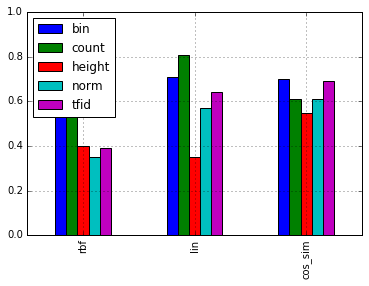

,bin,count,height,norm,tfid
rbf,0.70 (+/- 0.03),0.71 (+/- 0.08),0.40 (+/- 0.05),0.35 (+/- 0.00),0.39 (+/- 0.08)
lin,0.71 (+/- 0.03),0.81 (+/- 0.05),0.35 (+/- 0.00),0.57 (+/- 0.03),0.64 (+/- 0.05)
cos_sim,0.70 (+/- 0.03),0.61 (+/- 0.06),0.55 (+/- 0.05),0.61 (+/- 0.06),0.69 (+/- 0.07)


In [106]:
Kernels = ['rbf', 'lin', 'cos_sim']
representations = ['bin', 'count', 'tfid', 'norm', 'height']

results = []
for k in Kernels:
    d = {}
    for rep in representations:
        K = V_kernels[k][rep]
        K = K[idx][:,idx]
        svm_clf = svm.SVC(kernel="precomputed")
        scores = cross_validation.cross_val_score(svm_clf,K,y[idx],cv=5)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
        #print rep
        
    results.append(d)
svm_res = pd.DataFrame(results,index=Kernels)
plot_df(svm_res)
plt.show()
svm_res

### Added feats tree K

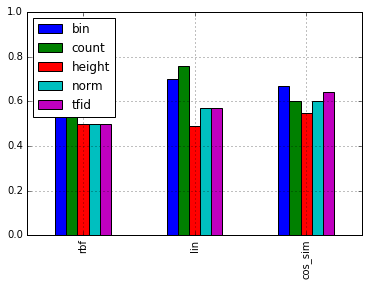

,bin,count,height,norm,tfid
rbf,0.66 (+/- 0.08),0.68 (+/- 0.08),0.50 (+/- 0.10),0.50 (+/- 0.07),0.50 (+/- 0.07)
lin,0.70 (+/- 0.04),0.76 (+/- 0.06),0.49 (+/- 0.08),0.57 (+/- 0.05),0.57 (+/- 0.05)
cos_sim,0.67 (+/- 0.08),0.60 (+/- 0.06),0.55 (+/- 0.06),0.60 (+/- 0.06),0.64 (+/- 0.08)


In [66]:
Kernels = ['rbf', 'lin', 'cos_sim']
representations = ['bin', 'count', 'tfid', 'norm', 'height']

results = []
for k in Kernels:
    d = {}
    for rep in representations:
        K = V_kernels[k][rep]
        K = K[idx][:,idx]+K_t[idx][:,idx]
        svm_clf = svm.SVC(kernel="precomputed")
        scores = cross_validation.cross_val_score(svm_clf,K,y[idx],cv=5)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
        #print rep
        
    results.append(d)
svm_res = pd.DataFrame(results,index=Kernels)
plot_df(svm_res)
plt.show()
svm_res

### Introspection du modèle

In [32]:
D = pickle.load(open('../../data/test/dicts.pkl','r'))

In [33]:
svm_lin_clf = svm.SVC(kernel='linear')
svm_lin_clf.fit(V['count'],y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
from sklearn import feature_extraction

vectorizer = feature_extraction.DictVectorizer(sparse=False)
V_bin = vectorizer.fit_transform(D['bin'])


w0 = svm_lin_clf.coef_[0].argsort()
pos0 = np.array(w0[-5:])

w1 = svm_lin_clf.coef_[1].argsort()
pos1 = np.array(w1[-5:])

w2 = svm_lin_clf.coef_[2].argsort()
pos2 = np.array(w2[-5:])

test0 = np.zeros((len(w0)))
test1 = np.zeros((len(w1)))
test2 = np.zeros((len(w2)))

test0[pos0] = 1
test1[pos1] = 1
test2[pos2] = 1

print vectorizer.inverse_transform(test0)
print ''
print vectorizer.inverse_transform(test1)
print ''
print vectorizer.inverse_transform(test2)

[{'NN-temporal': 1.0, 'NS-concession': 1.0, 'NS-temporal': 1.0, 'NS-example': 1.0, 'NS-antithesis': 1.0}]

[{'SN-attribution': 1.0, 'NS-temporal': 1.0, 'NN-sequence': 1.0, 'NN-list': 1.0, 'SN-antithesis': 1.0}]

[{'SN-condition': 1.0, 'NS-condition': 1.0, 'NS-temporal': 1.0, 'NS-manner': 1.0, 'NN-list': 1.0}]


/home/emmanuel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/emmanuel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/emmanuel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

### Random Forest

,bin,count,height,norm,tfid
0,0.64 (+/- 0.05),0.76 (+/- 0.05),0.77 (+/- 0.04),0.73 (+/- 0.06),0.74 (+/- 0.05)


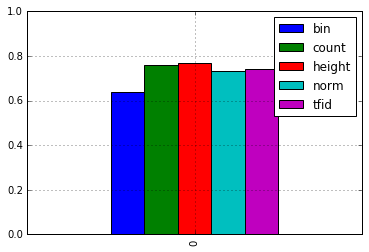

In [47]:
from sklearn import ensemble
results = []
d = {}
for rep in representations:
    rand_forest = ensemble.RandomForestClassifier()
    scores = cross_validation.cross_val_score(rand_forest,V[rep][idx],y[idx],cv=5)        
    d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
results.append(d)
rand_forest_res = pd.DataFrame(results,index=None)
plot_df(rand_forest_res)
rand_forest_res

### KNN

,bin,count,height,norm,tfid
eucl_dist,0.65 (+/- 0.07),0.70 (+/- 0.07),0.68 (+/- 0.04),0.59 (+/- 0.08),0.66 (+/- 0.04)
mink_dist,0.65 (+/- 0.07),0.70 (+/- 0.07),0.68 (+/- 0.04),0.59 (+/- 0.08),0.66 (+/- 0.04)


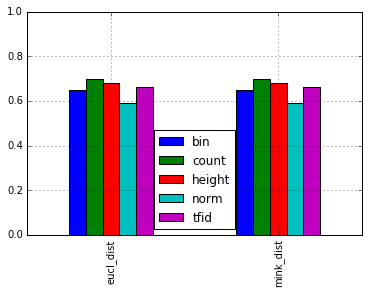

In [48]:
from sklearn import neighbors
metrics = ['eucl_dist','mink_dist']
representations = ['bin', 'count', 'tfid', 'norm', 'height']

results = []
for k in metrics:
    d = {}
    for rep in representations:
        K = V_kernels[k][rep]
        K = K[idx][:,idx]
        knn_clf = neighbors.KNeighborsClassifier(metric="precomputed")
        scores = cross_validation.cross_val_score(knn_clf,K,y[idx],cv=5)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
    results.append(d)
    
knn_res = pd.DataFrame(results,index=metrics)
plot_df(knn_res)
knn_res

### MaxEnt

,bin,count,height,norm,tfid
0,0.72 (+/- 0.02),0.81 (+/- 0.03),0.81 (+/- 0.02),0.58 (+/- 0.05),0.64 (+/- 0.04)


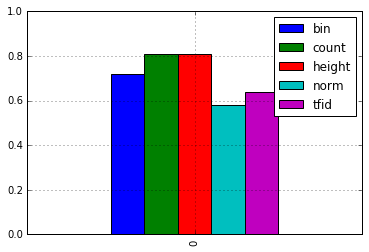

In [69]:
from sklearn import linear_model

results = []
d = {}
for rep in representations:
    maxent = linear_model.LogisticRegression()
    scores = cross_validation.cross_val_score(maxent,V[rep][idx],y[idx],cv=5)        
    d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
results.append(d)
maxent_res = pd.DataFrame(results,index=None)
plot_df(maxent_res)
maxent_res

In [241]:
import kernels
kernels.compute_gram(V_plus,V_plus,kernel=)

### Treekernel

In [57]:
K_t = pickle.load(open('../../data/test/tree_kernel.pkl'))

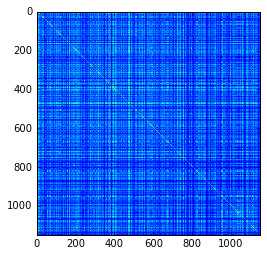

In [58]:
plt.imshow(K_t)

In [62]:
svm_clf = svm.SVC(kernel="precomputed")
scores = cross_validation.cross_val_score(svm_clf,K_t[idx][:,idx],y[idx],cv=5)        
d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
print scores

[ 0.47286822  0.5234375   0.4488189   0.43307087  0.54330709]


## Ajout de features

In [64]:
V_pos_norm = pickle.load(open('../data/pos_tags/pos_norm_vects.pkl',"r"))

In [74]:
V_pos_norm.shape

(1149, 41)

## maxent

                     bin                  count                 height  \
0     0.69   (+/- 0.03)      0.78   (+/- 0.01)      0.78   (+/- 0.01)    

                    norm                   tfid  
0     0.57   (+/- 0.04)      0.62   (+/- 0.07)   
                     bin                  count                 height  \
0     0.99   (+/- 0.01)      0.99   (+/- 0.01)      0.97   (+/- 0.00)    

                    norm                   tfid  
0     0.99   (+/- 0.01)      0.99   (+/- 0.01)   


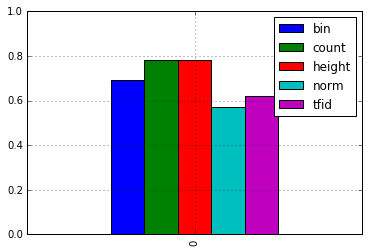

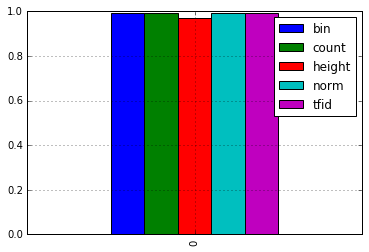

In [107]:
from sklearn import linear_model
for c in np.linspace(0,20,2):
    V_plus = {}
    for key in V.keys():
        V_plus[key] = np.hstack((V[key],c*V_pos_norm))
        #V_plus[key] = np.hstack((np.zeros((V[key].shape)),V_pos_norm))

    results = []
    d = {}
    for rep in representations:
        maxent = linear_model.LogisticRegression()
        #np.random.shuffle(range(len(V_plus)))
        #V_plus[rep][]
        scores = cross_validation.cross_val_score(maxent,V_plus[rep][idx],y[idx],cv=2)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
    results.append(d)
    maxent_res = pd.DataFrame(results,index=None)
    plot_df(maxent_res)
    print maxent_res

### Matrice de Confusion

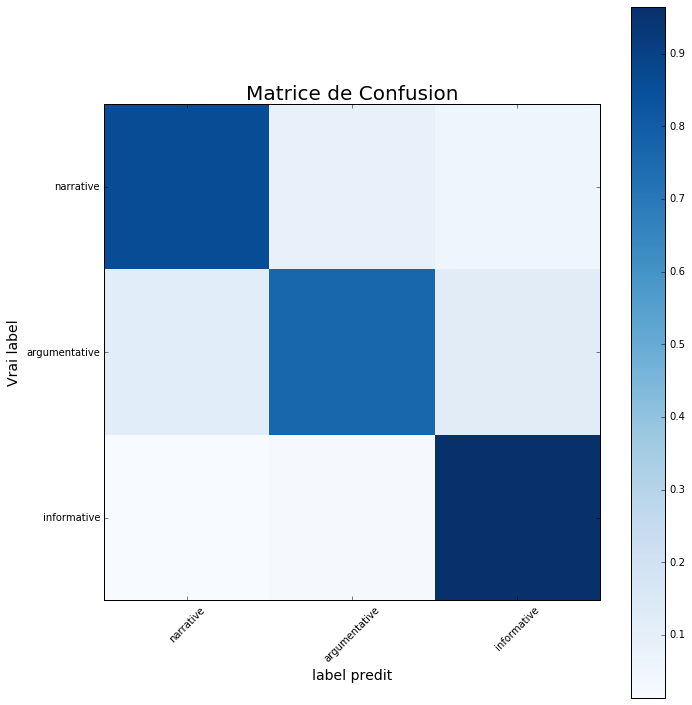

In [316]:
from sklearn import metrics
classes = ['narrative','argumentative','informative']

maxent.fit(V_plus[rep][idx],y[idx])
pred=maxent.predict(V_plus[rep][idx])
conf = metrics.confusion_matrix(y[idx],pred)

def plot_confusion_matrix(cm, title='Matrice de Confusion', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Vrai label',size=14)
    plt.xlabel('label predit',size=14)
    
norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(norm_conf)


## matrices de confusion

['rbf', 'lin', 'eucl_dist', 'cos_sim', 'mink_dist']
['bin', 'count', 'tfid', 'norm', 'height']


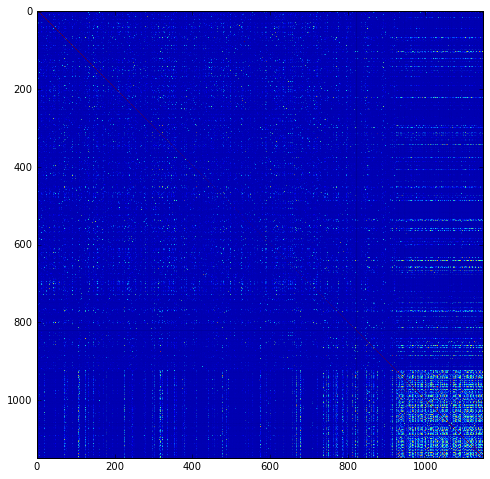

In [242]:
print vect_kernels.keys()
print vect_kernels['rbf'].keys()
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(vect_kernels['rbf']['norm']+vect_kernels['rbf']['height'])
plt.show()